# Oefening Data Cleaning en Modelling met Spark

**Deadline:** ...

In deze oefening wordt een dataset gebruikt die een overzicht van de films en series die op een bepaald moment beschikbaar waren via Netflix.
Deze dataset kan [hier](https://www.kaggle.com/shivamb/netflix-shows) gevonden worden.
Het doel in deze opgave is om te bekijken of we op basis van de beschrijving het type (serie of film) van de film te voorspellen.

Om te beginnen, download de dataset en upload hem naar je distributed file systeem onder het path: **Oefeningen/Spark**.
Voorzie ook code die deze folder reset naar een lege folder om geen naam-conflicten te hebben.

In [1]:
import opendatasets as od
import pydoop.hdfs as hdfs
import pandas as pd
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, sum, when, to_date, concat, lit, count, expr, trim, split, explode, rand
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import RegexTokenizer
from pyspark.sql.types import DoubleType
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import PipelineModel
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# download dataset
od.download("https://www.kaggle.com/shivamb/netflix-shows")

Skipping, found downloaded files in "./netflix-shows" (use force=True to force download)


In [3]:
# start from clean state
localFS = hdfs.hdfs(host='')
client = hdfs.hdfs(host='localhost', port=9000)

# if directory does not exists - make directory
if not client.exists('/Oefeningen/Spark'):
    client.create_directory('/Oefeningen/Spark')
client.set_working_directory('/Oefeningen/Spark')
print(client.working_directory())

# do some cleaning in case anything else than input.txt is present
for f in client.list_directory("."):
    if not f["name"].endswith("netflix_titles.csv"):
        client.delete(f["name"], True) # True om aan te geven dat folders ook verwijderd moeten worden

2023-04-01 20:22:32,611 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/Oefeningen/Spark


In [4]:
# upload de dataset naar hadoop
localFS.copy("./netflix-shows/netflix_titles.csv", client, "netflix_titles.csv") # upload file to hdfs

0

# Inladen dataset

Als eerste stap moeten we de dataset inlezen van het hdfs en er een DataFrame aanmaken.
Doe dit hieronder en print de volgende gegevens uit van het DataFrame:
* Het schema van het dataframe
* Het aantal rijen aanwezig in de dataframe
* De eerste 5 rijen
* Hoeveel nan or null-waarden zijn er aanwezig per kolom?

In [5]:
spark = SparkSession.builder.master('local[1]') \
                            .config("spark.driver.memory", "16g") \
                            .config('spark.executor.memory', '4g') \
                            .appName('SparkOefening') \
                            .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/01 20:22:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/01 20:22:49 WARN MacAddressUtil: Failed to find a usable hardware address from the network interfaces; using random bytes: b0:97:c9:1d:8f:05:84:6b


In [6]:
# Df inlezen
df = spark.read.csv('/Oefeningen/Spark/netflix_titles.csv', header=True, sep=',', quote='\"', escape='\"')

# Schema van df
print("Schema van df")
df.printSchema()

# Aantal rijen aanwezig in de df
print("Aantal rijen in df")
print(df.count())

# Eerste 5 rijen
print("Eerste 5 rijen in df")
df.show(5)

# Hoeveel nan or null per kolom
null_counts = df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns))
null_counts.show()

Schema van df
root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)

Aantal rijen in df
8807
Eerste 5 rijen in df
+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+--------------------+--------------------+
|show_id|   type|               title|       director|                cast|      country|        date_added|release_year|rating| duration|           listed_in|         description|
+-------+-------+--------------------+---------------+--------------------+-------------+---------

**Bekijk de datastructuur van het dataframe. Is het dataformaat van elke kolom zoals verwacht? Welke stappen moeten er ondernomen worden om de datastructuur te verbeteren van het dataframe?**

Neen, alles is als een string ingelezen. We moeten de kolommen aanpassen naar de correcte datatypes. De IDs kan je de s verwijderen en dan het nummer als id gebruiken. Release year word een integer want is alleen het jaar, en date added wordt een date

## Aanpassen datastructuur

Zorg er in de eerste stap voor dat de datatypes van de kolommen correct zijn. (getallen als integers, datums als dates, ...).
Vul daarna alle ontbrekende waarden in met een "unknown" voor tekstuele waarden en -1 voor integer waarden.
Kies voor de datums die ontbrekenen de eerste januari van het jaar waarin de film/serie is uitgebracht.
Als dit jaar ontbreekt, zorg ervoor dat de datum waarop de film is toegevoegd 1 januari 1990 is. Een tip hiervoor is om te werken met de .where() en .otherwise() functies

Verifieer de aanpassingen door opnieuw het schema uit te printen en de null waarden te tellen.

In [7]:
# aanpassen schema dataframe

# string kolommen opvullen: director, cast, country, rating, duration
df = df.fillna({
  'director': 'unknown',
  'cast': 'unknown',
  'country': 'unknown',
  'rating': 'unknown',
  'duration': 'unknown'
})

# date_added
df = df.withColumn("date_added", when(df["date_added"].isNull(), 
                             concat(lit("January 1, "), df["release_year"]))
                 .otherwise(df["date_added"]))

# id kolom s verwijderen en naar integer type
df = df.withColumn("show_id", regexp_replace(col("show_id"), "^s", "").cast("integer"))

# datum omvormen
df = df.withColumn("date_added", trim(df.date_added))
df = df.withColumn("date_added", to_date(df.date_added, "MMMM d, yyyy"))

# year als number (integer)
df = df.withColumn("release_year", col("release_year").cast("integer"))

print("Schema van df na aanpassingen")
df.printSchema()

null_counts = df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns))
null_counts.show()
df.show(5)

df_ready_freddy = df

Schema van df na aanpassingen
root
 |-- show_id: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = false)
 |-- cast: string (nullable = false)
 |-- country: string (nullable = false)
 |-- date_added: date (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- rating: string (nullable = false)
 |-- duration: string (nullable = false)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)

+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|show_id|type|title|director|cast|country|date_added|release_year|rating|duration|listed_in|description|
+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|      0|   0|    0|       0|   0|      0|         0|           0|     0|       0|        0|          0|
+-------+----+-----+--------+----+-------+----------+-----------

## Bestuderen dataset

Nu dat de data opgekuist is, is het mogelijk om een aantal zaken te berekenen voor het dataframe.
Beantwoord nu de volgende vragen:
* Hoeveel films en series zijn er aanwezig in het dataframe. 
* Hoeveel unieke ratings zijn er gekend?
* Bereken het aantal films gereleased in elk jaar (negeer de onbekenden)
* Hoeveel series hebben meer dan 5 seizoenen? Hoeveel films duren langer dan twee uur? Dit moet niet in 1 commando uitgevoerd worden.
* Welke film heeft de langste beschrijving? Indien er meerdere zijn met hetzelfde aantal, toon ze allemaal.
* Welke serie heeft de meeste acteurs? Indien er meerdere zijn met hetzelfde aantal, toon ze allemaal.
* Welk land heeft het meeste PG-13 films gemaakt? Tel enkel films die in hoogstens in 1 land opgenomen zijn. Indien er meerdere zijn met hetzelfde aantal, toon ze allemaal.
* Welke regisseurs hebben evenveel films als series gemaakt. Indien er meerdere zijn met hetzelfde aantal, toon ze allemaal.

In [8]:
# Vraag 1
df.createOrReplaceTempView("temp_table")

serie_count = df.sql_ctx.sql("SELECT COUNT(*) AS serie_count FROM temp_table WHERE type = 'TV Show'").collect()[0]["serie_count"]
film_count = df.sql_ctx.sql("SELECT COUNT(*) AS film_count FROM temp_table WHERE type = 'Movie'").collect()[0]["film_count"]

print("Aantal series:", serie_count)
print("Aantal filmen", film_count)

/home/bigdata/anaconda3/lib/python3.8/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Aantal series: 2676
Aantal filmen 6131


In [9]:
# Vraag 2
num_distinct_ratings = df.sql_ctx.sql("SELECT COUNT(DISTINCT rating) AS num_distinct_ratings FROM temp_table").collect()[0]["num_distinct_ratings"]

print("Aantal unieke ratings:", num_distinct_ratings)

Aantal unieke ratings: 18


In [10]:
# Vraag 3
result_df = spark.sql("SELECT release_year, COUNT(*) AS count FROM temp_table WHERE type = 'Movie' GROUP BY release_year ORDER BY release_year")
result_df.show(150)

+------------+-----+
|release_year|count|
+------------+-----+
|        1942|    2|
|        1943|    3|
|        1944|    3|
|        1945|    3|
|        1946|    1|
|        1947|    1|
|        1954|    2|
|        1955|    3|
|        1956|    2|
|        1958|    3|
|        1959|    1|
|        1960|    4|
|        1961|    1|
|        1962|    3|
|        1963|    1|
|        1964|    2|
|        1965|    2|
|        1966|    1|
|        1967|    4|
|        1968|    3|
|        1969|    2|
|        1970|    2|
|        1971|    5|
|        1972|    4|
|        1973|   10|
|        1974|    6|
|        1975|    7|
|        1976|    9|
|        1977|    6|
|        1978|    7|
|        1979|   10|
|        1980|   11|
|        1981|   12|
|        1982|   17|
|        1983|   11|
|        1984|   12|
|        1985|    9|
|        1986|   11|
|        1987|    8|
|        1988|   16|
|        1989|   15|
|        1990|   19|
|        1991|   16|
|        1992|   20|
|        1993

In [11]:
# Vraag 4.1
result_df = spark.sql("SELECT COUNT(*) AS count FROM (SELECT CAST(REGEXP_REPLACE(duration, ' Seasons', '') AS INT) AS duration_int FROM temp_table WHERE type = 'TV Show') subquery WHERE duration_int > 5").collect()[0]["count"]

print("Aantal series met meer als 5 seizoenen:", result_df)

# Vraag 4.2
result_df2 = spark.sql("SELECT COUNT(*) AS count FROM (SELECT CAST(REGEXP_REPLACE(duration, ' min', '') AS INT) AS duration_int FROM temp_table WHERE type = 'Movie') subquery WHERE duration_int > 120").collect()[0]["count"]
print("Aantal films die langer duren dan 2 uur:", result_df2)

Aantal series met meer als 5 seizoenen: 99
Aantal films die langer duren dan 2 uur: 1142


In [12]:
# Vraag 5
# eerst max length opvragen, dan alle records waar length overeenkomt met max length
result_df = spark.sql("SELECT * FROM (SELECT *, MAX(LENGTH(description)) OVER () AS max_len FROM temp_table WHERE type = 'Movie') subquery WHERE LENGTH(description) = max_len")
result_df.show()

23/04/01 20:23:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/01 20:23:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/01 20:23:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/01 20:23:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/01 20:23:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+-------+-----+---------------+-------------------+--------------------+-------+----------+------------+------+--------+--------------------+--------------------+-------+
|sho

In [13]:
# Vraag 6
result_df = spark.sql("SELECT * FROM (SELECT *, MAX(size(split(cast, ', '))) OVER () AS max_len FROM temp_table WHERE type = 'TV Show') subquery WHERE size(split(cast, ', ')) = max_len")
result_df.show()

23/04/01 20:23:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/01 20:23:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/01 20:23:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/01 20:23:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/01 20:23:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+-------+-------+---------------+--------+--------------------+--------------+----------+------------+------+---------+--------------------+--------------------+-------+
|show

In [14]:
# Vraag 7

df7_tussenstap = spark.sql("SELECT *, size(split(country, ',')) AS country_size FROM temp_table")
df7_tussenstap.createOrReplaceTempView("temp_table2")
df7 = spark.sql("SELECT country, count(*) FROM temp_table2 WHERE type = 'Movie' AND rating = 'PG-13' AND country_size <= 1 GROUP BY country HAVING COUNT(*) = (SELECT COUNT(*) FROM temp_table2 WHERE type = 'Movie' AND rating = 'PG-13' AND country_size <= 1 GROUP BY country ORDER BY COUNT(*) DESC LIMIT 1 );")
df7.show()
# uniated states heeft 289 films met rating pg-13 gemaakt, als ze de enige waren als land die aan die film heeft gewerkt.

+-------------+--------+
|      country|count(1)|
+-------------+--------+
|United States|     289|
+-------------+--------+



In [15]:
# Vraag 8
# code houd rekening mee dat er soms aan 1 film of 1 serie meerdere directors zijn dus vandaar explode
df8 = df.withColumn('director', explode(split(df.director, ', ')))

df8 = df8.groupby('director').pivot('type', ['Movie', 'TV Show']).count().fillna(0)

df8.createOrReplaceTempView("temp_table3")
df9 = spark.sql("SELECT * FROM temp_table3 WHERE `Movie` = `TV Show`")
df9.show(150)

+------------------+-----+-------+
|          director|Movie|TV Show|
+------------------+-----+-------+
|     Patricia Font|    1|      1|
|     Alban Teurlai|    1|      1|
|        Tig Notaro|    1|      1|
|    Justin Webster|    1|      1|
|        Noam Murro|    1|      1|
| Tsutomu Mizushima|    1|      1|
|   Olivier Megaton|    1|      1|
|     Masaaki Yuasa|    1|      1|
|   Houda Benyamina|    1|      1|
|       Tosin Coker|    1|      1|
|     Steven Bognar|    1|      1|
|    Bunmi Ajakaiye|    1|      1|
|     Kim Seong-hun|    1|      1|
|        John Dower|    1|      1|
|     Mark Tonderai|    1|      1|
|      Ronna Gradus|    1|      1|
|       Oriol Paulo|    1|      1|
|       Faris Godus|    1|      1|
|        Andrew Tan|    1|      1|
|     Estela Renner|    1|      1|
|     Thomas Astruc|    1|      1|
|    Tensai Okamura|    1|      1|
|       Luis Alfaro|    1|      1|
|         Sion Sono|    1|      1|
|     Rashida Jones|    1|      1|
|    Julia Reichert|

## Trainen ML-model

In de volgende stap gaan we een ML-model trainen door een pipeline aan te maken waarin de beschrijving van een film of serie in het dataframe omgezet wordt in een featurevector en deze gebruikt wordt om het type te voorspellen (film of serie). Plaats alle benodigde stappen in een pipeline die minstens over de volgende stappen beschikt:
* Zet het type om naar een label
* Zet de beschrijving om naar tokens
* Verwijder de stopwoorden in deze tokens
* Tel hoeveel keer elk woord voorkomt (Term frequency is hier voldoend)
* Train een ML-model (regressie of classificatie?).

Train deze pipeline en zorg ervoor dat het uiteindelijke model opgeslagen wordt.
Zorg voor hyperparameter tuning (met een beperkt aantal combinaties).
Voor het trainen moet de beschikbare data ook verdeeld worden in een training en testdata om het uiteindelijke model te kunnen evalueren.

In [16]:
# Build pipeline
# #type kolom moet nog omgevormd worden naar een integer
df_ready_freddy = df_ready_freddy.withColumn("label", when(df["type"] == "Movie", 0).otherwise(1))

(training_data, test_data) = df_ready_freddy \
    .select(["description", "label"]) \
    .withColumn("rand", rand()) \
    .sort("rand") \
    .select("description", "label") \
    .randomSplit([0.7, 0.3], seed=6969)

tokenizer = RegexTokenizer(inputCol="description", outputCol="words", pattern="\\W")
stop_words_remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="filtered_words")
count_vectorizer = CountVectorizer(inputCol=stop_words_remover.getOutputCol(), outputCol="features")
lr = LogisticRegression(featuresCol="features", labelCol="label")

pipeline = Pipeline(stages=[tokenizer, stop_words_remover, count_vectorizer, lr])

In [17]:
# Train pipeline
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.threshold, [0.3, 0.5, 0.7]) \
    .build()

In [18]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                          numFolds=3)

In [19]:
cv_model = crossval.fit(training_data)

23/04/01 20:24:36 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/04/01 20:24:36 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


23/04/01 20:24:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/01 20:24:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [20]:
best_pipeline_model = cv_model.bestModel

lr_stage = best_pipeline_model.stages[-1]
print("Beste model zijn parameters:")
print("regParam:", lr_stage.getOrDefault("regParam"))
print("elasticNetParam:", lr_stage.getOrDefault("elasticNetParam"))
print("threshold:", lr_stage.getOrDefault("threshold"))

Beste model zijn parameters:
regParam: 1.0
elasticNetParam: 0.0
threshold: 0.3


In [21]:
# Save model
best_pipeline_model.save('/Oefeningen/Spark/bestmodel_lr')

## Evalueren ML-model

Vertrek nu vanaf het opgeslagen model door het in te laden vanaf het hadoop filesysteem.
Maak de voorspellingen van de training en testdata.
Gebruik nu de MulticlassMetrics klasse om de volgende metrieken te berekenen voor zowel trainings als testdata:
* Accuraatheid
* F1-score
* Confusion matrix
* Weighted Recall score

Let op dat de MulticlassMetrics niet het volledige dataframe verwacht maar enkel een reeks tuples met de voorspellingen en de echte labels.

In [22]:
# Inlezen pipeline via disk
loaded_pipeline_model = PipelineModel.load('/Oefeningen/Spark/bestmodel_lr')

In [23]:
# Maak voorspellingen
predictions = loaded_pipeline_model.transform(test_data)
predictions = predictions.withColumn("label", col("label").cast("double"))

predictions_and_labels = predictions.select("prediction", "label").rdd
predictions_and_labels = predictions_and_labels.map(lambda x: (x.prediction, x.label))

metrics = MulticlassMetrics(predictions_and_labels)

/home/bigdata/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [27]:
# Accuracy
accuracy = metrics.accuracy
print("Accuracy = %s" % accuracy)

Accuracy = 0.7141776937618147


In [28]:
# Weighted F1-score
weighted_f1_score = metrics.weightedFMeasure(beta=1.0)
print("Weighted F1-score = %s" % weighted_f1_score)

Weighted F1-score = 0.717943994227516


Confusion Matrix:
[[1374.  426.]
 [ 330.  515.]]


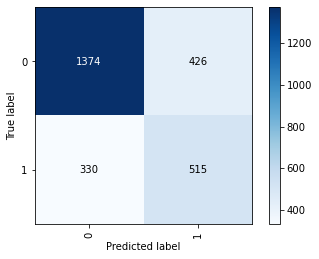

In [34]:
# Confusion matrix (thx chatgpt :D)
confusion_matrix = metrics.confusionMatrix().toArray()
print("Confusion Matrix:\n%s" % confusion_matrix)

classes = [str(i) for i in range(confusion_matrix.shape[0])]

fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap='Blues')

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.xaxis.set_tick_params(rotation=90)

cbar = ax.figure.colorbar(im, ax=ax)

thresh = confusion_matrix.max() / 2
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(j, i, format(confusion_matrix[i, j], '.0f'),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")

plt.show()

In [30]:
# Weighted Recall score
weighted_recall_score = metrics.weightedRecall
print("Weighted Recall Score = %s" % weighted_recall_score)

Weighted Recall Score = 0.7141776937618147
